In [3]:
import os
import cv2
import os
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__vsc_ipynb_file__), '../../')))
import torch
from gestures.setup import get_pc_cgf, setup_callbacks, setup_model
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix




In [6]:
def dopmap(x):
    xreal = x[:,0]
    ximag = x[:,1]
    x1 = torch.complex(xreal, ximag)
    return torch.abs(torch.fft.fftshift(torch.fft.fft(x1, dim=1), dim=1))


def plot_doppler1(x):
    plt.rcdefaults()
    # x = torch.tensor(x, dtype=torch.complex64)
    # x = torch.abs(torch.fft.fftshift(torch.fft.fft(x, dim=0), dim=0))
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    # Create the axis extent
    
    ax.imshow(x.cpu().numpy(), aspect='auto')
    extent = [100, 300, -110, 110]
    
    ax.imshow(x.cpu().numpy(), aspect='auto', extent=extent)
    # ax.imshow(x.cpu().numpy(), aspect='auto', extent=extent)

    ax.set_ylabel("Doppler Frequency [Hz]", fontsize=16)
    ax.set_xlabel("Distance To Sensor [mm]", fontsize=16)
    ax.set_xticks(np.arange(100, 301, 40))  # Adding custom ticks for x-axis
    ax.set_yticks(np.arange(-100, 101, 100))  # Adding custom ticks for y-axis
    ax.tick_params(axis='both', which='major', labelsize=14)

    
    plt.show()

In [60]:
from gestures.utils_processing_data import *
from gestures.data_loader2.dataset_factory import *


files = os.listdir("/Users/netanelblumenfeld/Downloads/11G/tt")
gestures = [
    "PinchIndex",
    "PinchPinky",
    "FingerSlider",
    "FingerRub",
    "SlowSwipeRL",
    "FastSwipeRL",
    "Push",
    "Pull",
    "PalmTilt",
    "Circle",
    "PalmHold",
    "NoHand",
]
base_dir = "/Users/netanelblumenfeld/Downloads/11G/tt"
task = "sr_classifier"  # task = ["sr", "classifier", "sr_classifier"]
pc, data_dir, output_dir, device = get_pc_cgf()


batch_size = 100
dx, dy = 4,4
pre_processing_funcs = {
    "classifier": torch.nn.Sequential(
        ToTensor(),
        DownSampleOneSample(dx=dx, dy=dy, original_dims=False),
        NormalizeOneSample(),
        DopplerMapOneSample(),
    ),
    "sr_classifier": {
        "hr": torch.nn.Sequential(
            ToTensor(), NormalizeOneSample(), ComplexToRealOneSample()
        ),
        "lr": torch.nn.Sequential(
            ToTensor(),
            DownSampleOneSample(dx=dx, dy=dy, original_dims=False),
            NormalizeOneSample(),
            ComplexToRealOneSample(),
        ),
    },
    "sr": {
        "hr": torch.nn.Sequential(
            ToTensor(), NormalizeOneSample(), ComplexToRealOneSample()
        ),
        "lr": torch.nn.Sequential(
            ToTensor(),
            DownSampleOneSample(dx=dx, dy=dy, original_dims=False),
            NormalizeOneSample(),
            ComplexToRealOneSample(),
        ),
    },

}

data_loader = get_data_loader(
    task, batch_size, gestures, data_dir, pre_processing_funcs[task]
)

sr_model_path ="/Users/netanelblumenfeld/Desktop/bgu/Msc/code/out_laptop/sr/SAFMN_loss_L1/dsx_4_dsy_4_original_dim_False/2024-07-10_19:53:18/model/total_loss.pth"
cr_class_model_path_g1 ="/Users/netanelblumenfeld/Desktop/bgu/Msc/code/out/sr_classifier/sr_SAFMN_classifier_TinyRadar_sr_loss_L11_classifier_loss_TinyLoss1/dsx_4_dsy_4_original_dim_False/2024-07-08_12:21:25/model/total_loss.pth"


In [41]:
from gestures.network.models.basic_model import BasicModel
from gestures.network.models.super_resolution.safmn import SAFMN


sr_model,_,ep,lo = BasicModel.load_pre_train_model(device=torch.device("cpu"), model_dir=sr_model_path)
print(ep,lo)
sr_clas_model,_,ep,lo = BasicModel.load_pre_train_model(device=torch.device("cpu"), model_dir=cr_class_model_path_g1)


96 0.06184643916453116


In [42]:
for x,y in data_loader['val']:
    lr_imgs = x
    hr_imgs = y
    print(lr_imgs.shape, hr_imgs.shape)
    break
lr_imgs,hr_imgs = sr_model.reshape_to_model_output(lr_imgs,hr_imgs,torch.device("cpu"))
sr_img = sr_model(lr_imgs)
sr_img_dop = dopmap(sr_img)
hr_img_dop = dopmap(hr_imgs)
lr_img_dop = dopmap(lr_imgs)




torch.Size([10, 5, 2, 2, 8, 123]) torch.Size([10, 5, 2, 2, 32, 492])


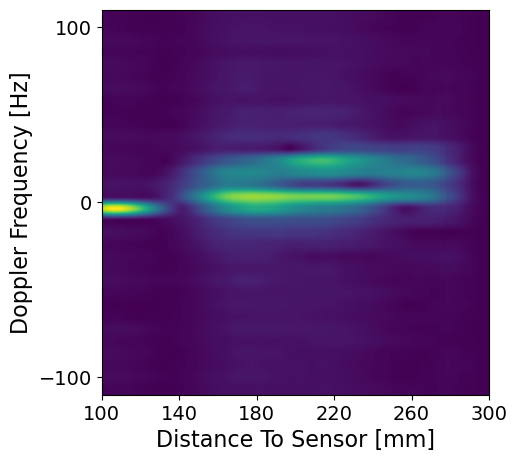

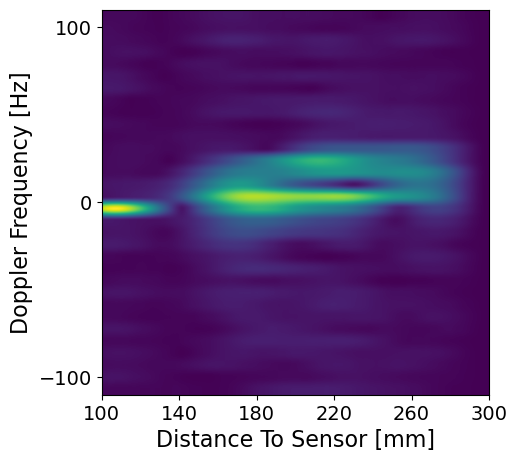

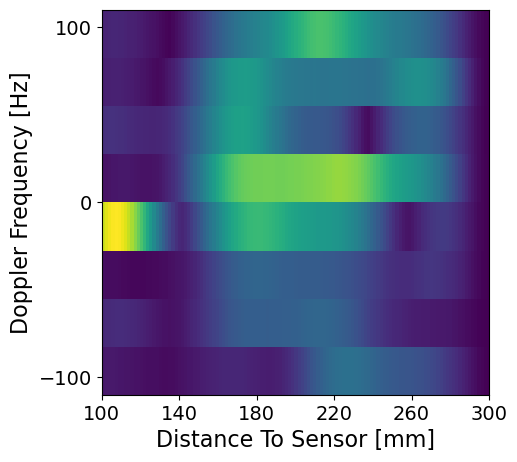

In [43]:
plot_doppler1(sr_img_dop[0].detach())
plot_doppler1(hr_img_dop[0].detach())
plot_doppler1(lr_img_dop[0].detach())

In [61]:
for x,y in data_loader['val']:
    lr_imgs = x
    hr_imgs = y[0]
    print(lr_imgs.shape, hr_imgs.shape)
    break
lr_imgs,hr_imgs = sr_clas_model.reshape_to_model_output(lr_imgs,y,torch.device("cpu"))





torch.Size([100, 5, 2, 2, 8, 123]) torch.Size([100, 5, 2, 2, 32, 492])


In [62]:
sr_img = sr_clas_model(lr_imgs)


In [63]:
import torch
import io

# Example model
model = torch.nn.Linear(10, 2)

# Save the model state dictionary to a buffer
buffer = io.BytesIO()
torch.save(sr_clas_model.state_dict(), buffer)
buffer.seek(0, io.SEEK_END)

# Get the size in bytes
size_in_bytes = buffer.tell()

# Convert bytes to megabytes
size_in_mb = size_in_bytes / (1024 * 1024)
print(f"Model size: {size_in_mb:.2f} MB")


Model size: 1.13 MB


In [30]:
sr_img_dop = dopmap(sr_img[0])
hr_img_dop = dopmap(hr_imgs[0])
lr_img_dop = dopmap(lr_imgs)


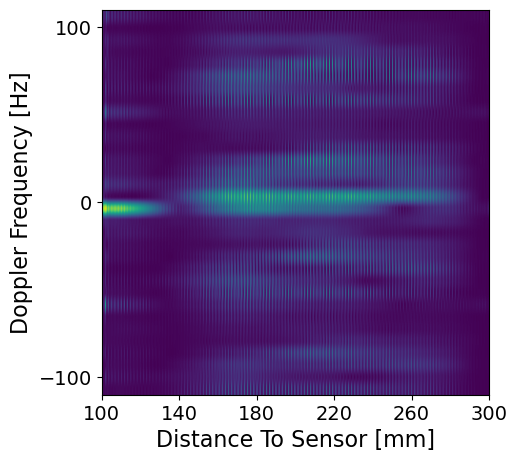

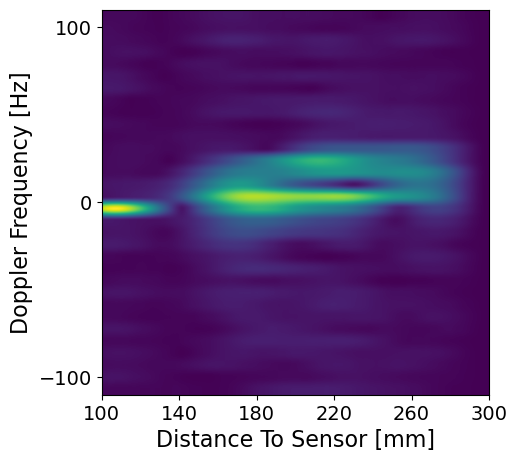

In [36]:
plot_doppler1(sr_img_dop[0].detach())
plot_doppler1(hr_img_dop[0].detach())

In [ ]:
x = [1,2,3,4,5,7,8,16]
y = [0.8954, 0.8759, 0.8586, 0.8466, 0.8267, 0.7938, 0.7741, 0.7023]

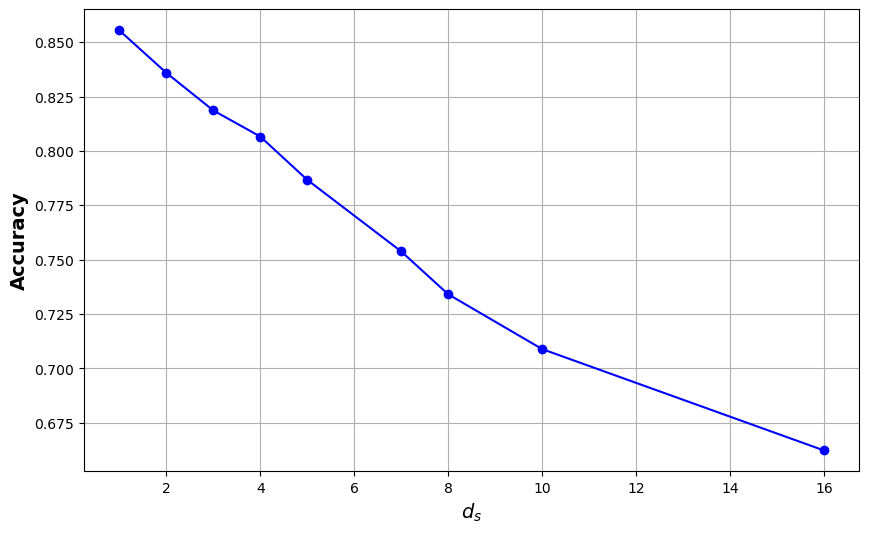

In [53]:
import matplotlib.pyplot as plt

x = [1, 2, 3, 4, 5, 7, 8, 10 ,16]
y = [0.8954, 0.8759, 0.8586, 0.8466, 0.8267, 0.7938, 0.7741, 0.7489 ,0.7023]
y1 = np.array(y) - 0.04

plt.figure(figsize=(10, 6))
plt.plot(x, y1, marker='o', linestyle='-', color='b')

plt.xlabel("$d_s$", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy", fontsize=14, fontweight="bold")
plt.grid(True)
plt.show()


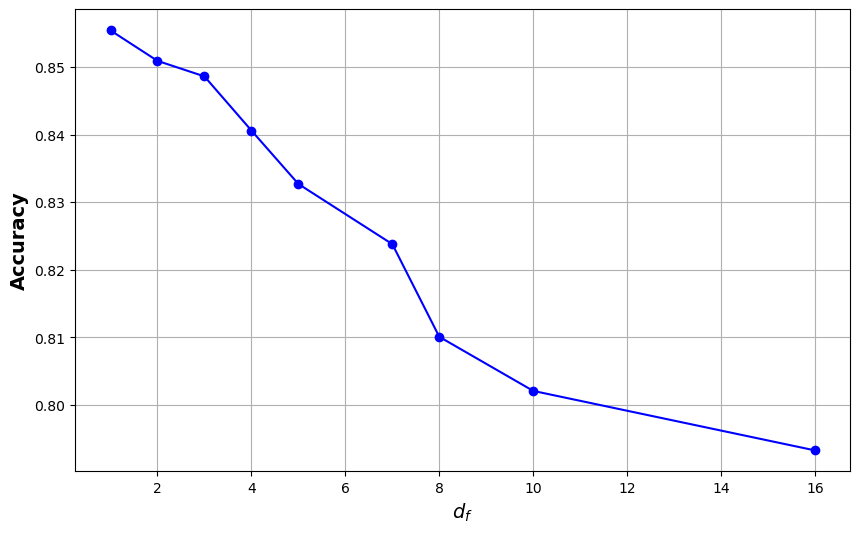

In [11]:
import matplotlib.pyplot as plt

x = [1, 2, 3, 4, 5, 7, 8, 10 ,16]
y = [0.8954, 0.8909, 0.8886, 0.8806, 0.8727, 0.8638, 0.8501, 0.8421 ,0.8333]
y1 = np.array(y) - 0.04

plt.figure(figsize=(10, 6))
plt.plot(x, y1, marker='o', linestyle='-', color='b')

plt.xlabel("$d_f$", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy", fontsize=14, fontweight="bold")
plt.grid(True)
plt.show()


In [47]:
def v1(x,y):
    xx = np.power(x,2)
    yy = np.power(y,2)
    return yy + xx/(1+xx)
def v2(x,y):
    xx = np.power(x,2)
    yy = np.power(y,2)
    return 6*xx+3*yy -2*x*y


In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcdefaults()

# Define the value of c
c_values = [ 0 , 0.5, 1, 2, 4]

# Create a grid of points
x = np.linspace(-1, 1, 300)
y = np.linspace(-1, 1, 300)
X, Y = np.meshgrid(x, y)

# Define the function
# Z = X**2 + Y**2
Z = v2(X,Y)

# Plot the level sets
plt.figure(figsize=(20, 12))
cp = plt.contour(X, Y, Z, levels=c_values)
plt.clabel(cp, inline=True, fontsize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


NameError: name 'v2' is not defined

In [8]:
import os
import os
import cv2
import os
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__vsc_ipynb_file__), '../../')))
import torch
from gestures.configs import new_config as cfg1
from gestures.data_loader2.dataset_factory import get_data_loader
from gestures.network.callbacks.callback_logger import get_time_in_string
from gestures.network.models.basic_model import BasicModel
from gestures.network.runner2 import Runner, validate
from gestures.setup import get_pc_cgf, setup_callbacks, setup_model
from gestures.utils_processing_data import (
    ComplexToRealOneSample,
    DopplerMapOneSample,
    DownSampleOneSample,
    NormalizeOneSample,
    ToTensor,
)





if __name__ == "__main__":
    model_path = "/Users/netanelblumenfeld/Desktop/bgu/Msc/code/out/classifier/TinyRadar_loss_TinyLoss/dsx_4_dsy_4_original_dim_True/2024-06-30_17:19:55/model/total_loss.pth"

    pc, data_dir, output_dir, device = get_pc_cgf()
    task = "classifier"  # task = ["sr", "classifier", "sr_classifier"]
    original_dims = True if task == "classifier" else False
    for x in [1]:
        for dim in [36]:
            batch_size = 30
            dx, dy = 4, 4
            epochs = 70

            gestures = [
                "PinchIndex",
                "PinchPinky",
                "FingerSlider",
                "FingerRub",
                "SlowSwipeRL",
                "FastSwipeRL",
                "Push",
                "Pull",
                "PalmTilt",
                "Circle",
                "PalmHold",
                "NoHand",
            ]
            pre_processing_funcs = {
                "classifier": torch.nn.Sequential(
                    ToTensor(),
                    DownSampleOneSample(dx=dx, dy=dy, original_dims=original_dims),
                    NormalizeOneSample(),
                    DopplerMapOneSample(),
                ),
                "sr_classifier": {
                    "hr": torch.nn.Sequential(
                        ToTensor(), NormalizeOneSample(), ComplexToRealOneSample()
                    ),
                    "lr": torch.nn.Sequential(
                        ToTensor(),
                        DownSampleOneSample(dx=dx, dy=dy, original_dims=original_dims),
                        NormalizeOneSample(),
                        ComplexToRealOneSample(),
                    ),
                },
                "sr": {
                    "hr": torch.nn.Sequential(
                        ToTensor(), NormalizeOneSample(), ComplexToRealOneSample()
                    ),
                    "lr": torch.nn.Sequential(
                        ToTensor(),
                        DownSampleOneSample(dx=dx, dy=dy, original_dims=original_dims),
                        NormalizeOneSample(),
                        ComplexToRealOneSample(),
                    ),
                },
            }

            data_loader = get_data_loader(
                task, batch_size, gestures, data_dir, pre_processing_funcs[task]
            )

            # getting model
            qq, optimizer, acc, loss_metric = setup_model(
                task=task,
                model_cfg=cfg1.model_config,
                device=device,
            )
            model, _, _, _ = BasicModel.load_pre_train_model(device, model_path)

            loss_metric.reset()
            acc.reset()
            validate(model, data_loader["test"], device, loss_metric, acc)
            print(acc.value)
            print(loss_metric.value)


187
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
{'acc_ClassifierAccuracy': 0.8511237959025643}
{'total_loss': 0.4471512749625548, 'loss_TinyLoss': 0.4471512749625548}


In [9]:
def get_pred_true_labels(task, acc_metric):
    if task == "classifier":
        true = acc_metric.metrics["ClassifierAccuracy"].true_labels
        pred = acc_metric.metrics["ClassifierAccuracy"].pred_labels
    elif task == "sr_classifier":
        true = acc_metric.classifier_acc.metrics["ClassifierAccuracy"].true_labels
        pred = acc_metric.classifier_acc.metrics["ClassifierAccuracy"].pred_labels
    else:
        raise ValueError(f"Unknown task: {task}")
    return true, pred

In [10]:
true_labels, pred_labels = get_pred_true_labels(task, acc)
preds = np.concatenate(pred_labels, axis=0)
trues = np.concatenate(true_labels, axis=0)
cm = confusion_matrix(trues, preds)


In [11]:
np.save("cm_dx_4_dy_4_lr.npy", cm)